<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv3/blob/main/2_DNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy import sparse
import gdown
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [2]:
download_link = 'https://drive.google.com/uc?id=12iud4h19CZst4exbr3U2A9iDxBYvZ5U_'
output_filepath = '/content/'
gdown.download(download_link, output_filepath)

Downloading...
From: https://drive.google.com/uc?id=12iud4h19CZst4exbr3U2A9iDxBYvZ5U_
To: /content/X_redefined_sparse_matrix.npz
100%|██████████| 2.31M/2.31M [00:00<00:00, 17.0MB/s]


'/content/X_redefined_sparse_matrix.npz'

In [3]:
download_link = 'https://drive.google.com/uc?id=1IhrcT3jHqlPrw2KvQ5vJkBgozxcJ1cJm'
output_filepath = '/content/'
gdown.download(download_link, output_filepath)

Downloading...
From: https://drive.google.com/uc?id=1IhrcT3jHqlPrw2KvQ5vJkBgozxcJ1cJm
To: /content/labels.pt
100%|██████████| 517k/517k [00:00<00:00, 5.92MB/s]


'/content/labels.pt'

In [5]:
# Load dataset
X_redefined = sparse.load_npz("X_redefined_sparse_matrix.npz")
labels_tensor = torch.load('labels.pt')

In [7]:
# Split data into train, validation, and test sets with stratified sampling
X_train_val, X_test, labels_train_val, labels_test = train_test_split(X_redefined, labels_tensor, test_size=0.2, stratify=labels_tensor, random_state=42)
X_train, X_val, labels_train, labels_val = train_test_split(X_train_val, labels_train_val, test_size=0.2, stratify=labels_train_val, random_state=42)

# Combine features and labels into datasets
train_dataset = TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.float32), labels_train)
val_dataset = TensorDataset(torch.tensor(X_val.toarray(), dtype=torch.float32), labels_val)
test_dataset = TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.float32), labels_test)


In [8]:
# Define the DataLoader for training, validation, and test sets
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class MalwareClassifier(nn.Module):
    def __init__(self, dropout_prob):
        super(MalwareClassifier, self).__init__()
        # Define input size
        input_size = 10000
        # Define hidden layer sizes
        hidden_size = 200

        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout with specified probability
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout with specified probability
        self.fc3 = nn.Linear(hidden_size, 1)  # Output layer with single neuron for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

    def forward(self, x):
        # Forward pass
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)  # Sigmoid activation for binary classification
        return out


In [10]:
# Create an instance of the model with dropout probability of 0.6
model = MalwareClassifier(dropout_prob=0.6)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_X, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_X)

        # Compute loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    # Evaluate on validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_labels in val_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_labels).item()

            # Convert probabilities to predicted labels
            predicted = torch.round(outputs)

            # Count correct predictions
            correct += (predicted == batch_labels).sum().item()

            # Count total samples
            total += batch_labels.size(0)

    val_loss /= len(val_loader)
    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}')

# Optionally, save the trained model
# torch.save(model.state_dict(), 'malware_classifier.pth')


Epoch [1/10], Training Loss: 0.0155
Epoch [1/10], Validation Loss: 0.0328, Validation Accuracy: 0.9907
Epoch [2/10], Training Loss: 0.0243
Epoch [2/10], Validation Loss: 0.0254, Validation Accuracy: 0.9930
Epoch [3/10], Training Loss: 0.0551
Epoch [3/10], Validation Loss: 0.0241, Validation Accuracy: 0.9931
Epoch [4/10], Training Loss: 0.0024
Epoch [4/10], Validation Loss: 0.0235, Validation Accuracy: 0.9940
Epoch [5/10], Training Loss: 0.0029
Epoch [5/10], Validation Loss: 0.0249, Validation Accuracy: 0.9939
Epoch [6/10], Training Loss: 0.0067
Epoch [6/10], Validation Loss: 0.0217, Validation Accuracy: 0.9947
Epoch [7/10], Training Loss: 0.0431
Epoch [7/10], Validation Loss: 0.0225, Validation Accuracy: 0.9948
Epoch [8/10], Training Loss: 0.0009
Epoch [8/10], Validation Loss: 0.0250, Validation Accuracy: 0.9943
Epoch [9/10], Training Loss: 0.0405
Epoch [9/10], Validation Loss: 0.0249, Validation Accuracy: 0.9947
Epoch [10/10], Training Loss: 0.0018
Epoch [10/10], Validation Loss: 0.02

In [12]:
# Save model parameters
torch.save(model.state_dict(), 'DNN_params.pth')

In [13]:
# Evaluate the trained model on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for X_batch, labels_batch in test_loader:
        outputs = model(X_batch)
        predicted = torch.round(outputs)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels_batch.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate test accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Test Accuracy: 0.9939
Precision: 0.9723
Recall: 0.8831
F1-score: 0.9255


In [14]:
# Calculate true positives, true negatives, false positives, and false negatives
TP = ((predictions == 1) & (true_labels == 1)).sum()
TN = ((predictions == 0) & (true_labels == 0)).sum()
FP = ((predictions == 1) & (true_labels == 0)).sum()
FN = ((predictions == 0) & (true_labels == 1)).sum()

print(f'True Positives (TP): {TP}')
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 982
True Negatives (TN): 24663
False Positives (FP): 28
False Negatives (FN): 130


In [17]:
#here , we define prediction, as probability(not binary)

# Evaluate the trained model on the test set
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for X_batch, labels_batch in test_loader:
        outputs = model(X_batch)
        predictions.extend(outputs.tolist())
        true_labels.extend(labels_batch.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# Calculate F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1-score
best_f1_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f'Best F1-score: {best_f1_score:.4f} at threshold: {best_f1_threshold:.4f}')


Best F1-score: 0.9317 at threshold: 0.3666


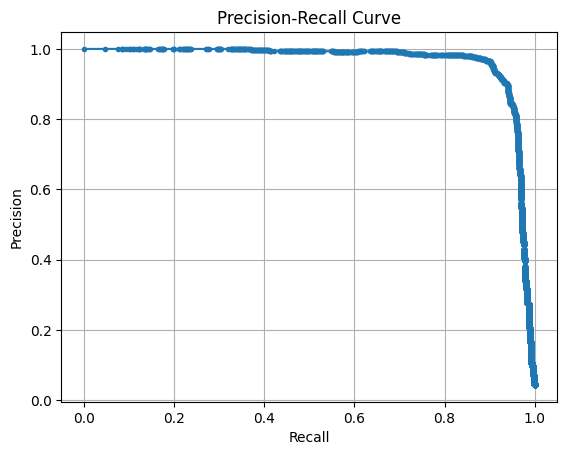

In [18]:

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


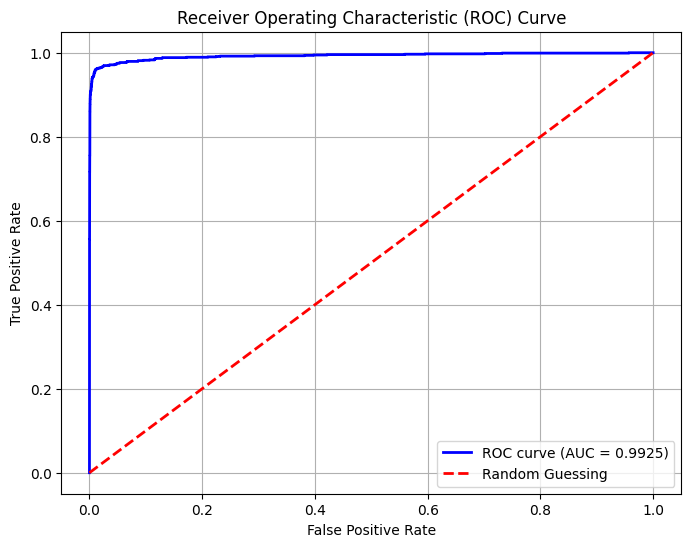

In [21]:
# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()